In [1]:
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
# Example dots
dots = [
    [0,1],
    [2,1],
    [3,7],
    [2,5],
    [1,8],
    [5,0],
    [6,7],
    [2,9],
    [4,4],
    [8,2],
    [5,1],
    [6,4],
    [2,5],
    [9,7],
]

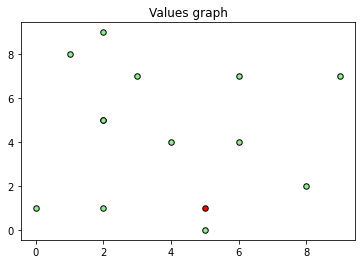

In [5]:
list_x = []
list_y = []

for i in range(len(dots)):
    if i == 10:
        plt.scatter([dots[i][0]],[dots[i][1]],
            marker='o',
            s=30,
            c='red',
            edgecolors='black')
        continue
    list_x.append(dots[i][0])
    list_y.append(dots[i][1])

plt.scatter(list_x,list_y,
           marker='o',
           s=30,
           c='lightgreen',
           edgecolors='black')

plt.title('Values graph')
plt.show()

In [6]:
# distance_matrix 계산하는 부분

sample = [0]*len(dots)
distance_matrix = []

for i in range(len(dots)):
    single_distance_matrix = []
    if i == 0:
        distance_matrix.append(sample)
        continue
        
    for j in range(len(dots)):
        distance = abs(dots[i][0] - dots[j][0]) + abs(dots[i][1] - dots[j][1])
        single_distance_matrix.append(distance)
    
    distance_matrix.append(single_distance_matrix)
    
distance_matrix
        

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 0, 7, 4, 8, 4, 10, 8, 5, 7, 3, 7, 4, 13],
 [9, 7, 0, 3, 3, 9, 3, 3, 4, 10, 8, 6, 3, 6],
 [6, 4, 3, 0, 4, 8, 6, 4, 3, 9, 7, 5, 0, 9],
 [8, 8, 3, 4, 0, 12, 6, 2, 7, 13, 11, 9, 4, 9],
 [6, 4, 9, 8, 12, 0, 8, 12, 5, 5, 1, 5, 8, 11],
 [12, 10, 3, 6, 6, 8, 0, 6, 5, 7, 7, 3, 6, 3],
 [10, 8, 3, 4, 2, 12, 6, 0, 7, 13, 11, 9, 4, 9],
 [7, 5, 4, 3, 7, 5, 5, 7, 0, 6, 4, 2, 3, 8],
 [9, 7, 10, 9, 13, 5, 7, 13, 6, 0, 4, 4, 9, 6],
 [5, 3, 8, 7, 11, 1, 7, 11, 4, 4, 0, 4, 7, 10],
 [9, 7, 6, 5, 9, 5, 3, 9, 2, 4, 4, 0, 5, 6],
 [6, 4, 3, 0, 4, 8, 6, 4, 3, 9, 7, 5, 0, 9],
 [15, 13, 6, 9, 9, 11, 3, 9, 8, 6, 10, 6, 9, 0]]

In [10]:
# time window 계산
time_window = [
    (0, 100),
    (0, 100),
    (0, 100),
    (0, 100),
    (0, 100),
    (0, 100),
    (0, 100),
    (0, 100),
    (0, 100),
    (0, 100),
    (15, 100),
    (0, 100),
    (0, 100),
    (0, 100),
]

time_window

[(0, 100),
 (0, 100),
 (0, 100),
 (0, 100),
 (0, 100),
 (0, 100),
 (0, 100),
 (0, 100),
 (0, 100),
 (0, 100),
 (15, 100),
 (0, 100),
 (0, 100),
 (0, 100)]

In [15]:
def create_data_model():
    data = {}
    data['time_matrix'] = distance_matrix
    data['time_windows'] = time_window
    data['num_vehicles'] = 3
    data['depot'] = 0
    return data

In [16]:
# Instance the data problem
data = create_data_model()

In [17]:
# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),data['num_vehicles'], data['depot'])

In [18]:
# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

In [20]:
# Create and register a transit callback.
def time_callback(from_index, to_index):
    """Returns the travel time between the two nodes."""
    # Convert from routing variable Index to time matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

In [21]:
transit_callback_index = routing.RegisterTransitCallback(time_callback)

In [22]:
# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)# Define cost of each arc.

In [23]:
# Add Time Windows constraint.
time = 'Time'
routing.AddDimension(
    transit_callback_index,
    30,  # allow waiting time
    30,  # maximum time per vehicle
    False,  # Don't force start cumul to zero.
    time)
time_dimension = routing.GetDimensionOrDie(time)
# Add time window constraints for each location except depot.
for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == data['depot']:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
# Add time window constraints for each vehicle start node.
depot_idx = data['depot']
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(
        data['time_windows'][depot_idx][0],
        data['time_windows'][depot_idx][1])


In [24]:
# Instantiate route start and end times to produce feasible times.
for i in range(data['num_vehicles']):
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.Start(i)))
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.End(i)))

In [25]:
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)